**환경에 대한 정의 : Maze**
- state_to_pos : state는 스칼라 값인 반면, pos는 벡터이다. 두 값 사이의 변환이 필요하다.
- pos_to_state : 위 과정의 역 과정이다.
- take_action : state에서 action을 취했을 때 결과를 출력한다. 장애물이나 미로 밖으로 갔을 때는 -1, False 를 반환하고, goal에 도달했을 때는 1, True를 출력한다.

In [24]:
import numpy as np

class Maze:
    def __init__(self):
        self.maze = np.zeros((5, 5))
        self.maze[1, 1] = -1  # obstacle
        self.maze[3, 3] = -1  # obstacle
        self.maze[4, 4] = 1   # goal

    def state_to_pos(self, state):
        return (state // 5, state % 5)

    def pos_to_state(self, pos):
        return pos[0] * 5 + pos[1]

    def take_action(self, state, action):
        x, y = self.state_to_pos(state)

        if action == 0:  # up
            x -= 1
        elif action == 1:  # down
            x += 1
        elif action == 2:  # left
            y -= 1
        elif action == 3:  # right
            y += 1

        if x < 0 or x >= 5 or y < 0 or y >= 5:
            return state, -1, False

        if self.maze[x, y] == -1:
            return state, -1, False

        if self.maze[x, y] == 1:
            return self.pos_to_state((x, y)), 1, True

        return self.pos_to_state((x, y)), 0, False
    def print_maze(self, now_pos=False):
        if now_pos != False :
            temp = self.maze[now_pos[0]][now_pos[1]]
            self.maze[now_pos[0]][now_pos[1]] = 2
        for row in self.maze:
            printed_row = []
            for cell in row:
                if cell == 0:
                    printed_row.append(' ')
                elif cell == 1:
                    printed_row.append('G')  # Goal
                elif cell == -1:
                    printed_row.append('O')  # Obstacle
                elif cell == 2 :
                    printed_row.append('P')
            print('|' + '|'.join(printed_row) + '|')
        print()
        if now_pos != False :
            self.maze[now_pos[0]][now_pos[1]] = temp

**학습 부분**
1. 필요한 파라미터와 State, Action, Reward 등을 초기화
2. 시작 state로부터 앱실론 그리디를 통하여 액션을 취함
3. action을 실행하여 환경으로부터, 다음 state, reward, done을 받음
4. Q테이블 업데이트 (식은 아래 첨부)
5. done=True 라면 종료, 에피소드를 재시작
6. Q테이블이 수렴되면 종료 (아래 코드에서는 10000번 실행시 수렴한다고 가정)
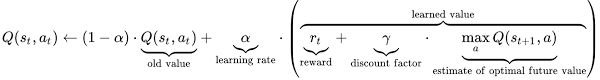

In [25]:
# q_learning.py
import numpy as np

alpha = 0.5
gamma = 0.6
epsilon = 0.1
num_episodes = 10000

num_states = 25  
num_actions = 4  
Q_table = np.zeros((num_states, num_actions)) # 처음에는 0으로 초기화되어있는 Q테이블

maze = Maze()

for i_episode in range(num_episodes):
    state = 0  
    done = False
    print(Q_table, end='\n')
    while not done:  
        # 앱실론 그리디
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.choice(num_actions)  
        else:
            action = np.argmax(Q_table[state])  
        # action 실횅
        next_state, reward, done = maze.take_action(state, action)
        # Q테이블 업데이트
        Q_table[state, action] = (1 - alpha) * Q_table[state, action] \
                                + alpha * (reward + gamma * np.max(Q_table[next_state]))
        # state를 다음 state로
        state = next_state

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[-1.          0.         -1.          0.        ]
 [-1.         -1.          0.          0.        ]
 [-1.          0.          0.          0.        ]
 [-1.          0.          0.          0.        ]
 [-1.          0.          0.         -1.        ]
 [ 0.          0.         -1.         -1.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.         -1.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.         -1.        ]
 [ 0.          0.         -1.          0.        ]
 [-1.          0.          0.          0.        ]
 [ 0.       

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



첫 업데이트가 오래 걸리는 이유에 대한 생각 : 미로 밖으로 갔을 때 -1의 reward를 받는다. 이는 Q테이블 업데이트에 영향을 주고, Q테이블이 많이 업데이트 되어있지 않은 상태에서는 사람이 미로 밖으로 나가지 못하게 하는 요인이 없다. 하지만 -1의 reward를 이용해 충분히 업데이트된 후에는 미로 밖으로 가는 action이 뽑힐 확률이 현저히 적어진다.

**업데이트된 Q테이블 테스트**

In [26]:
# Test the trained agent
state = 0
done = False
x = 0
y = 0
pos = (x, y)
while not done:
    maze.print_maze(pos)
    action = np.argmax(Q_table[state])  # 학습단계와 다르게 앱실론 그리디를 하지 않는다.
    next_state, reward, done = maze.take_action(state, action) 
    state = next_state  

    x, y = maze.state_to_pos(state)
    pos = (x, y)
    print(f"Agent moved to position: ({x}, {y})")
    
    if done and reward == 1:
        print("goal에 도착")
    elif done and reward == -1:
        print("장애물에 도착")

|P| | | | |
| |O| | | |
| | | | | |
| | | |O| |
| | | | |G|

Agent moved to position: (0, 1)
| |P| | | |
| |O| | | |
| | | | | |
| | | |O| |
| | | | |G|

Agent moved to position: (0, 2)
| | |P| | |
| |O| | | |
| | | | | |
| | | |O| |
| | | | |G|

Agent moved to position: (1, 2)
| | | | | |
| |O|P| | |
| | | | | |
| | | |O| |
| | | | |G|

Agent moved to position: (2, 2)
| | | | | |
| |O| | | |
| | |P| | |
| | | |O| |
| | | | |G|

Agent moved to position: (2, 3)
| | | | | |
| |O| | | |
| | | |P| |
| | | |O| |
| | | | |G|

Agent moved to position: (2, 4)
| | | | | |
| |O| | | |
| | | | |P|
| | | |O| |
| | | | |G|

Agent moved to position: (3, 4)
| | | | | |
| |O| | | |
| | | | | |
| | | |O|P|
| | | | |G|

Agent moved to position: (4, 4)
goal에 도착


결과 분석 : 장애물을 피하고 적절히 goal에 도착한다.

**---------------------------------------------------------------------------------------**  
**다른 미로에 관하여**  
랜덤으로 미로를 생성하고 그에 따른 해결 방법 도출

In [55]:
class Maze:
    def __init__(self):
        self.size = 20
        self.maze = np.zeros((self.size, self.size))
        # 미로 랜덤 생성
        for i in range(100) :
            self.maze[np.random.randint(0, self.size)][np.random.randint(0, self.size)] = -1
        self.maze[0, 0] = 0
        self.maze[self.size-1, self.size-1] = 1   

    def state_to_pos(self, state):
        return (state // self.size, state % self.size)

    def pos_to_state(self, pos):
        return pos[0] * self.size + pos[1]

    def take_action(self, state, action):
        x, y = self.state_to_pos(state)

        if action == 0:  # up
            x -= 1
        elif action == 1:  # down
            x += 1
        elif action == 2:  # left
            y -= 1
        elif action == 3:  # right
            y += 1

        if x < 0 or x >= self.size or y < 0 or y >= self.size:
            return state, -1, False

        if self.maze[x, y] == -1:
            return state, -1, False

        if self.maze[x, y] == 1:
            return self.pos_to_state((x, y)), 1, True
        # 일정 구간의 반복이 있길래 시간이 지날수록 음의 reward를 받도록 하였다.
        return self.pos_to_state((x, y)), -0.01, False 
    def print_maze(self, now_pos=False):
        if now_pos != False :
            temp = self.maze[now_pos[0]][now_pos[1]]
            self.maze[now_pos[0]][now_pos[1]] = 2
        for row in self.maze:
            printed_row = []
            for cell in row:
                if cell == 0:
                    printed_row.append(' ')
                elif cell == 1:
                    printed_row.append('G') 
                elif cell == -1:
                    printed_row.append('O')  
                elif cell == 2 :
                    printed_row.append('P')
            print('|' + '|'.join(printed_row) + '|')
        print()
        # 경로가 보여지도록 아래의 코드를 지움
        #if now_pos != False :
        #    self.maze[now_pos[0]][now_pos[1]] = temp

In [56]:
# 랜덤으로 생성되는 미로
maze = Maze()
maze.print_maze()
# 골에 도달할 방법이 없을 수도 있기 때문에 확인할 수 있어야함

| | | | | | |O| | |O| | | |O| | | |O|O| |
| | | | | | | |O| | | |O| | | | | |O| | |
| | | |O| | |O| | | | |O| | | | | |O| | |
| |O| |O| |O| | | | |O| | | |O| | | | |O|
| | | | |O| | | |O|O|O| | |O| | |O| | | |
| | | | | | | |O| | | | | | | | | | | |O|
|O|O| | |O| | | | | |O|O| | | | | | | |O|
| | | | | | | |O|O|O| | |O| | | |O| | | |
| | | |O| | | | | | | | | | | |O| | |O| |
| | | | | | | | | |O|O|O|O| | | |O| | |O|
| | | | |O| | | |O| | |O| | |O| |O| | | |
| | | |O|O| |O| | | | | |O| | | | | | | |
| | | | | | | | |O| | | |O| | | | |O| | |
| | |O| | | | |O|O| | |O| | |O|O| | | | |
| | |O| | | | | | | | |O| | |O| |O|O| | |
| | | | |O| | | | | | | | | |O|O| | | | |
| | | | | | | | | | | | | |O|O| | | | | |
| | | |O| | | | | | | |O| | |O|O| |O| | |
| |O|O| | | | |O| | | | | | | | | | | | |
| | | | | | | |O| | | |O| | | | | | | |G|



In [57]:
import numpy as np

alpha = 0.5
gamma = 0.6
epsilon = 0.1
num_episodes = 10000
size = maze.size
num_states = size*size # state의 수는 10 * 10개 이다.  
num_actions = 4 # action의 수는 변하지 않는다.
Q_table = np.zeros((num_states, num_actions)) 

pos = (0, 0)
for i_episode in range(num_episodes):
    state = 0  
    done = False
    print(i_episode, end=' ')
    print("완료")
    while not done:  
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.choice(num_actions)  
        else:
            action = np.argmax(Q_table[state])  
        x, y = maze.state_to_pos(state)
        pos = (x, y)
        next_state, reward, done = maze.take_action(state, action)
        Q_table[state, action] = (1 - alpha) * Q_table[state, action] \
                                + alpha * (reward + gamma * np.max(Q_table[next_state]))
        state = next_state

0 완료
1 완료
2 완료
3 완료
4 완료
5 완료
6 완료
7 완료
8 완료
9 완료
10 완료
11 완료
12 완료
13 완료
14 완료
15 완료
16 완료
17 완료
18 완료
19 완료
20 완료
21 완료
22 완료
23 완료
24 완료
25 완료
26 완료
27 완료
28 완료
29 완료
30 완료
31 완료
32 완료
33 완료
34 완료
35 완료
36 완료
37 완료
38 완료
39 완료
40 완료
41 완료
42 완료
43 완료
44 완료
45 완료
46 완료
47 완료
48 완료
49 완료
50 완료
51 완료
52 완료
53 완료
54 완료
55 완료
56 완료
57 완료
58 완료
59 완료
60 완료
61 완료
62 완료
63 완료
64 완료
65 완료
66 완료
67 완료
68 완료
69 완료
70 완료
71 완료
72 완료
73 완료
74 완료
75 완료
76 완료
77 완료
78 완료
79 완료
80 완료
81 완료
82 완료
83 완료
84 완료
85 완료
86 완료
87 완료
88 완료
89 완료
90 완료
91 완료
92 완료
93 완료
94 완료
95 완료
96 완료
97 완료
98 완료
99 완료
100 완료
101 완료
102 완료
103 완료
104 완료
105 완료
106 완료
107 완료
108 완료
109 완료
110 완료
111 완료
112 완료
113 완료
114 완료
115 완료
116 완료
117 완료
118 완료
119 완료
120 완료
121 완료
122 완료
123 완료
124 완료
125 완료
126 완료
127 완료
128 완료
129 완료
130 완료
131 완료
132 완료
133 완료
134 완료
135 완료
136 완료
137 완료
138 완료
139 완료
140 완료
141 완료
142 완료
143 완료
144 완료
145 완료
146 완료
147 완료
148 완료
149 완료
150 완료
151 완료
152 완료
153 완료
154 완료
155 완료
156 완료
157 완료
158 

2017 완료
2018 완료
2019 완료
2020 완료
2021 완료
2022 완료
2023 완료
2024 완료
2025 완료
2026 완료
2027 완료
2028 완료
2029 완료
2030 완료
2031 완료
2032 완료
2033 완료
2034 완료
2035 완료
2036 완료
2037 완료
2038 완료
2039 완료
2040 완료
2041 완료
2042 완료
2043 완료
2044 완료
2045 완료
2046 완료
2047 완료
2048 완료
2049 완료
2050 완료
2051 완료
2052 완료
2053 완료
2054 완료
2055 완료
2056 완료
2057 완료
2058 완료
2059 완료
2060 완료
2061 완료
2062 완료
2063 완료
2064 완료
2065 완료
2066 완료
2067 완료
2068 완료
2069 완료
2070 완료
2071 완료
2072 완료
2073 완료
2074 완료
2075 완료
2076 완료
2077 완료
2078 완료
2079 완료
2080 완료
2081 완료
2082 완료
2083 완료
2084 완료
2085 완료
2086 완료
2087 완료
2088 완료
2089 완료
2090 완료
2091 완료
2092 완료
2093 완료
2094 완료
2095 완료
2096 완료
2097 완료
2098 완료
2099 완료
2100 완료
2101 완료
2102 완료
2103 완료
2104 완료
2105 완료
2106 완료
2107 완료
2108 완료
2109 완료
2110 완료
2111 완료
2112 완료
2113 완료
2114 완료
2115 완료
2116 완료
2117 완료
2118 완료
2119 완료
2120 완료
2121 완료
2122 완료
2123 완료
2124 완료
2125 완료
2126 완료
2127 완료
2128 완료
2129 완료
2130 완료
2131 완료
2132 완료
2133 완료
2134 완료
2135 완료
2136 완료
2137 완료
2138 완료
2139 완료
2140 완료
2141 완료


3124 완료
3125 완료
3126 완료
3127 완료
3128 완료
3129 완료
3130 완료
3131 완료
3132 완료
3133 완료
3134 완료
3135 완료
3136 완료
3137 완료
3138 완료
3139 완료
3140 완료
3141 완료
3142 완료
3143 완료
3144 완료
3145 완료
3146 완료
3147 완료
3148 완료
3149 완료
3150 완료
3151 완료
3152 완료
3153 완료
3154 완료
3155 완료
3156 완료
3157 완료
3158 완료
3159 완료
3160 완료
3161 완료
3162 완료
3163 완료
3164 완료
3165 완료
3166 완료
3167 완료
3168 완료
3169 완료
3170 완료
3171 완료
3172 완료
3173 완료
3174 완료
3175 완료
3176 완료
3177 완료
3178 완료
3179 완료
3180 완료
3181 완료
3182 완료
3183 완료
3184 완료
3185 완료
3186 완료
3187 완료
3188 완료
3189 완료
3190 완료
3191 완료
3192 완료
3193 완료
3194 완료
3195 완료
3196 완료
3197 완료
3198 완료
3199 완료
3200 완료
3201 완료
3202 완료
3203 완료
3204 완료
3205 완료
3206 완료
3207 완료
3208 완료
3209 완료
3210 완료
3211 완료
3212 완료
3213 완료
3214 완료
3215 완료
3216 완료
3217 완료
3218 완료
3219 완료
3220 완료
3221 완료
3222 완료
3223 완료
3224 완료
3225 완료
3226 완료
3227 완료
3228 완료
3229 완료
3230 완료
3231 완료
3232 완료
3233 완료
3234 완료
3235 완료
3236 완료
3237 완료
3238 완료
3239 완료
3240 완료
3241 완료
3242 완료
3243 완료
3244 완료
3245 완료
3246 완료
3247 완료
3248 완료


4379 완료
4380 완료
4381 완료
4382 완료
4383 완료
4384 완료
4385 완료
4386 완료
4387 완료
4388 완료
4389 완료
4390 완료
4391 완료
4392 완료
4393 완료
4394 완료
4395 완료
4396 완료
4397 완료
4398 완료
4399 완료
4400 완료
4401 완료
4402 완료
4403 완료
4404 완료
4405 완료
4406 완료
4407 완료
4408 완료
4409 완료
4410 완료
4411 완료
4412 완료
4413 완료
4414 완료
4415 완료
4416 완료
4417 완료
4418 완료
4419 완료
4420 완료
4421 완료
4422 완료
4423 완료
4424 완료
4425 완료
4426 완료
4427 완료
4428 완료
4429 완료
4430 완료
4431 완료
4432 완료
4433 완료
4434 완료
4435 완료
4436 완료
4437 완료
4438 완료
4439 완료
4440 완료
4441 완료
4442 완료
4443 완료
4444 완료
4445 완료
4446 완료
4447 완료
4448 완료
4449 완료
4450 완료
4451 완료
4452 완료
4453 완료
4454 완료
4455 완료
4456 완료
4457 완료
4458 완료
4459 완료
4460 완료
4461 완료
4462 완료
4463 완료
4464 완료
4465 완료
4466 완료
4467 완료
4468 완료
4469 완료
4470 완료
4471 완료
4472 완료
4473 완료
4474 완료
4475 완료
4476 완료
4477 완료
4478 완료
4479 완료
4480 완료
4481 완료
4482 완료
4483 완료
4484 완료
4485 완료
4486 완료
4487 완료
4488 완료
4489 완료
4490 완료
4491 완료
4492 완료
4493 완료
4494 완료
4495 완료
4496 완료
4497 완료
4498 완료
4499 완료
4500 완료
4501 완료
4502 완료
4503 완료


5907 완료
5908 완료
5909 완료
5910 완료
5911 완료
5912 완료
5913 완료
5914 완료
5915 완료
5916 완료
5917 완료
5918 완료
5919 완료
5920 완료
5921 완료
5922 완료
5923 완료
5924 완료
5925 완료
5926 완료
5927 완료
5928 완료
5929 완료
5930 완료
5931 완료
5932 완료
5933 완료
5934 완료
5935 완료
5936 완료
5937 완료
5938 완료
5939 완료
5940 완료
5941 완료
5942 완료
5943 완료
5944 완료
5945 완료
5946 완료
5947 완료
5948 완료
5949 완료
5950 완료
5951 완료
5952 완료
5953 완료
5954 완료
5955 완료
5956 완료
5957 완료
5958 완료
5959 완료
5960 완료
5961 완료
5962 완료
5963 완료
5964 완료
5965 완료
5966 완료
5967 완료
5968 완료
5969 완료
5970 완료
5971 완료
5972 완료
5973 완료
5974 완료
5975 완료
5976 완료
5977 완료
5978 완료
5979 완료
5980 완료
5981 완료
5982 완료
5983 완료
5984 완료
5985 완료
5986 완료
5987 완료
5988 완료
5989 완료
5990 완료
5991 완료
5992 완료
5993 완료
5994 완료
5995 완료
5996 완료
5997 완료
5998 완료
5999 완료
6000 완료
6001 완료
6002 완료
6003 완료
6004 완료
6005 완료
6006 완료
6007 완료
6008 완료
6009 완료
6010 완료
6011 완료
6012 완료
6013 완료
6014 완료
6015 완료
6016 완료
6017 완료
6018 완료
6019 완료
6020 완료
6021 완료
6022 완료
6023 완료
6024 완료
6025 완료
6026 완료
6027 완료
6028 완료
6029 완료
6030 완료
6031 완료


7516 완료
7517 완료
7518 완료
7519 완료
7520 완료
7521 완료
7522 완료
7523 완료
7524 완료
7525 완료
7526 완료
7527 완료
7528 완료
7529 완료
7530 완료
7531 완료
7532 완료
7533 완료
7534 완료
7535 완료
7536 완료
7537 완료
7538 완료
7539 완료
7540 완료
7541 완료
7542 완료
7543 완료
7544 완료
7545 완료
7546 완료
7547 완료
7548 완료
7549 완료
7550 완료
7551 완료
7552 완료
7553 완료
7554 완료
7555 완료
7556 완료
7557 완료
7558 완료
7559 완료
7560 완료
7561 완료
7562 완료
7563 완료
7564 완료
7565 완료
7566 완료
7567 완료
7568 완료
7569 완료
7570 완료
7571 완료
7572 완료
7573 완료
7574 완료
7575 완료
7576 완료
7577 완료
7578 완료
7579 완료
7580 완료
7581 완료
7582 완료
7583 완료
7584 완료
7585 완료
7586 완료
7587 완료
7588 완료
7589 완료
7590 완료
7591 완료
7592 완료
7593 완료
7594 완료
7595 완료
7596 완료
7597 완료
7598 완료
7599 완료
7600 완료
7601 완료
7602 완료
7603 완료
7604 완료
7605 완료
7606 완료
7607 완료
7608 완료
7609 완료
7610 완료
7611 완료
7612 완료
7613 완료
7614 완료
7615 완료
7616 완료
7617 완료
7618 완료
7619 완료
7620 완료
7621 완료
7622 완료
7623 완료
7624 완료
7625 완료
7626 완료
7627 완료
7628 완료
7629 완료
7630 완료
7631 완료
7632 완료
7633 완료
7634 완료
7635 완료
7636 완료
7637 완료
7638 완료
7639 완료
7640 완료


8816 완료
8817 완료
8818 완료
8819 완료
8820 완료
8821 완료
8822 완료
8823 완료
8824 완료
8825 완료
8826 완료
8827 완료
8828 완료
8829 완료
8830 완료
8831 완료
8832 완료
8833 완료
8834 완료
8835 완료
8836 완료
8837 완료
8838 완료
8839 완료
8840 완료
8841 완료
8842 완료
8843 완료
8844 완료
8845 완료
8846 완료
8847 완료
8848 완료
8849 완료
8850 완료
8851 완료
8852 완료
8853 완료
8854 완료
8855 완료
8856 완료
8857 완료
8858 완료
8859 완료
8860 완료
8861 완료
8862 완료
8863 완료
8864 완료
8865 완료
8866 완료
8867 완료
8868 완료
8869 완료
8870 완료
8871 완료
8872 완료
8873 완료
8874 완료
8875 완료
8876 완료
8877 완료
8878 완료
8879 완료
8880 완료
8881 완료
8882 완료
8883 완료
8884 완료
8885 완료
8886 완료
8887 완료
8888 완료
8889 완료
8890 완료
8891 완료
8892 완료
8893 완료
8894 완료
8895 완료
8896 완료
8897 완료
8898 완료
8899 완료
8900 완료
8901 완료
8902 완료
8903 완료
8904 완료
8905 완료
8906 완료
8907 완료
8908 완료
8909 완료
8910 완료
8911 완료
8912 완료
8913 완료
8914 완료
8915 완료
8916 완료
8917 완료
8918 완료
8919 완료
8920 완료
8921 완료
8922 완료
8923 완료
8924 완료
8925 완료
8926 완료
8927 완료
8928 완료
8929 완료
8930 완료
8931 완료
8932 완료
8933 완료
8934 완료
8935 완료
8936 완료
8937 완료
8938 완료
8939 완료
8940 완료


In [58]:
state = 0
done = False
x = 0
y = 0
pos = (x, y)
while not done:
    maze.print_maze(pos)
    action = np.argmax(Q_table[state])  # 학습단계와 다르게 앱실론 그리디를 하지 않는다.
    next_state, reward, done = maze.take_action(state, action) 
    state = next_state  

    x, y = maze.state_to_pos(state)
    pos = (x, y)
    print(f"Agent moved to position: ({x}, {y})")
    
    if done and reward == 1:
        print("goal에 도착")
    elif done and reward == -1:
        print("장애물에 도착")

|P| | | | | |O| | |O| | | |O| | | |O|O| |
| | | | | | | |O| | | |O| | | | | |O| | |
| | | |O| | |O| | | | |O| | | | | |O| | |
| |O| |O| |O| | | | |O| | | |O| | | | |O|
| | | | |O| | | |O|O|O| | |O| | |O| | | |
| | | | | | | |O| | | | | | | | | | | |O|
|O|O| | |O| | | | | |O|O| | | | | | | |O|
| | | | | | | |O|O|O| | |O| | | |O| | | |
| | | |O| | | | | | | | | | | |O| | |O| |
| | | | | | | | | |O|O|O|O| | | |O| | |O|
| | | | |O| | | |O| | |O| | |O| |O| | | |
| | | |O|O| |O| | | | | |O| | | | | | | |
| | | | | | | | |O| | | |O| | | | |O| | |
| | |O| | | | |O|O| | |O| | |O|O| | | | |
| | |O| | | | | | | | |O| | |O| |O|O| | |
| | | | |O| | | | | | | | | |O|O| | | | |
| | | | | | | | | | | | | |O|O| | | | | |
| | | |O| | | | | | | |O| | |O|O| |O| | |
| |O|O| | | | |O| | | | | | | | | | | | |
| | | | | | | |O| | | |O| | | | | | | |G|

Agent moved to position: (1, 0)
|P| | | | | |O| | |O| | | |O| | | |O|O| |
|P| | | | | | |O| | | |O| | | | | |O| | |
| | | |O| | |O| | | | |O| | | | | |O| | |
|

수정한 환경을 바탕으로 p의 경로를 확인할 수 있음